# Similarity / Distance between Devices

In [1]:
from aux import *
import pandas as pd
from thefuzz import fuzz
import numpy as np
import json
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
plt.style.use('default')

## Devices SDF definitions

### Adapt SDF definition data for analysis

In [2]:
# Load SDF files to compare
sdf_manager = SDFManager(path='../iot/sdf/')
sdfs = sdf_manager.get_all_sdfs()

In [3]:
# Turn the SDF files into dataframes - Avoid redundant data
sdfs_trans = {}
columns = ['thing','thing_desc','obj','obj_desc','prop','prop_desc','prop_type','prop_unit']
rows = []
for name, sdf in sdfs.items() :
    if name == 'Auxiliary':
        continue
    for sdfThing, thing_dic in sdf['sdfThing'].items():
        thing_desc = thing_dic['description']
        for sdfObject, object_dic in thing_dic['sdfObject'].items():
            object_desc = object_dic['description']
            for sdfProperty, prop_dic in object_dic['sdfProperty'].items():
                if sdfProperty == 'uuid': continue
                prop_desc = prop_dic['description']
                prop_type = prop_dic['type']
                prop_unit = prop_dic['unit'] if 'unit' in prop_dic else None
                rows.append((sdfThing,thing_desc,sdfObject,object_desc,sdfProperty,prop_desc,prop_type,prop_unit))

sdfs_df = pd.DataFrame(columns=columns,data=rows)

In [4]:
# Air Quality SDF DATAFRAME
sdfs_df[sdfs_df.thing=='AirQualityModified'].iloc[:,2:].reset_index(drop=True)

,obj,obj_desc,prop,prop_desc,prop_type,prop_unit
0,temperature_humidity_sensor,Measures environmental temperature and humidity.,temperature,Temperature value,number,Cel
1,temperature_humidity_sensor,Measures environmental temperature and humidity.,humidity,Humidity value,number,%
2,air_quality_sensor,Measures air pollutants.,pm25,PM2.5 value,number,ug/m3
3,air_quality_sensor,Measures air pollutants.,pm10,PM10 value,number,ug/m3


## Devices data

### Load devices data

In [92]:
# Read devices data samples from JSON
with open('devices.json', 'r') as f: devices = json.load(f)

### Adapt devices data for analysis

In [93]:
# Build devices dataframe
rows = []
for dev_uuid, dev in devices.items() :
    # Dev row initialization
    row = {
        'uuid': dev_uuid,
        'dev' : dev['name'],
        'integ': dev['integrated'],
        'timestamp': dev['timestamp'],
        'period': dev['period']
    }
        
    # Create a row for each module attribute with a column for each value in the buffer
    for mod_uuid, mod in dev['modules'].items() :
        row['mod'] = mod['name']
        for prop_name, buffer in mod['attribs'].items() :
            row['attrib'] = prop_name
            for i, val in enumerate(buffer) :
                row[f'v{i+1}'] = val
            rows.append(row.copy())

# Build devices dataframe
devs_df = pd.DataFrame(rows)

In [94]:
# Drop columns without useful information
devs_df = devs_df.drop(columns=['integ','timestamp','period'])

## Similarity Analysis
Given an unknown device, determine the 5 closest devices according to SDF definition similarity, and then choose the closest device by including the buffered data. 

**Possible algorithm**

    Given an unknown device(thing) module(object) attribute(property), find 5 closest thing-object-property tuples according to SDF definition.

    Then, for each unknown module attribute, determine which attribute resembles the most to it of those in the 5 closest devices, and vote this device UUID as the candidate to be the closest.

    Finally, the device that has the most attribute votes is chosen as the closest device.

In [95]:
# Value columns names
n_vals = 50
val_cols = [f'v{i+1}' for i in range(n_vals)]

# Turn booleans into integers and cast all data to float
devs_df[val_cols] = devs_df[val_cols].replace('False',0).replace('True',1)
devs_df[val_cols] = devs_df[val_cols].astype(float)

In [96]:
# Air Quality Modified DEVICES DATAFRAME
devs_df[devs_df.dev=='AirQualityModified']

,uuid,dev,mod,attrib,v1,v2,v3,v4,v5,v6,...,v91,v92,v93,v94,v95,v96,v97,v98,v99,v100
273,c0ff5b20-fadb-49a4-978b-8187a6381385,AirQualityModified,temperature_humidity_sensor,temperature,24.119026,24.143762,24.145346,24.240457,24.310746,24.330542,...,24.503841,24.631302,24.625593,25.039193,24.876641,24.909207,24.934225,25.259249,25.269964,25.384091
274,c0ff5b20-fadb-49a4-978b-8187a6381385,AirQualityModified,temperature_humidity_sensor,humidity,28.369888,28.262538,28.287362,28.148010,28.103728,28.248166,...,28.143639,28.160059,28.225335,28.247628,28.341062,28.307246,28.337913,28.224796,28.212024,28.316882
275,c0ff5b20-fadb-49a4-978b-8187a6381385,AirQualityModified,air_quality_sensor,pm25,7.858604,7.896213,8.171176,7.967142,8.155234,8.082216,...,7.011621,7.056476,7.045594,7.251204,7.011224,7.03776,7.036574,7.073402,7.11378,7.076941
276,c0ff5b20-fadb-49a4-978b-8187a6381385,AirQualityModified,air_quality_sensor,pm10,21.125449,21.136380,21.327375,21.263077,21.542366,21.470879,...,21.763394,21.962647,21.596333,21.592988,21.303304,21.343686,21.58445,21.465724,21.545453,21.130666


In [142]:
# Unknown device
unknown_dev_name = 'AirQualityModified'

### Determine closest devices by SDF comparison

String similarity of the fields:
- Thing and its description
- Object and its description
- Property and its description

In [143]:
unknown_sdf = sdfs_df[sdfs_df.thing==unknown_dev_name]
known_sdfs = sdfs_df[sdfs_df.thing!=unknown_dev_name]

In [170]:
# Define distance functions
def calc_str_dist(descs, row):
    return fuzz.ratio(descs,row['thing_desc'] + ' ' + row['obj'] + ' ' + row['obj_desc'] + ' ' + row['prop'] + ' ' + row['prop_desc'])

# Compute closest devices by SDF
def get_closest_devs_by_sdf(unknown_sdf,known_sdfs,i) :
    # Create local copies
    unknown_row = unknown_sdf.iloc[i].copy()
    knowns_alike = known_sdfs[known_sdfs.prop_type==unknown_row['prop_type']].copy()

    # Build joint description 
    descs = unknown_row['thing'] + ' ' + unknown_row['thing_desc'] + ' ' + unknown_row['obj'] + ' ' + unknown_row['obj_desc'] + ' ' + unknown_row['prop'] + ' ' + unknown_row['prop_desc']

    # Calc string distances
    knowns_alike['str_dist'] = knowns_alike.apply(lambda x: calc_str_dist(descs,x), axis=1)
    closest_things = knowns_alike[['thing','obj','prop','str_dist']].sort_values(by='str_dist',ascending=False)

    # Give points based on closeness
    score = 5
    vote = {}
    for row in closest_things.itertuples() :
        if score == 0 : break
        if row.uuid in vote : continue
        vote[row.uuid] = score
        score -= 1
        
    return vote
        
    return vote

In [171]:
# Compute distance for each unknown module attribute
votes = (Parallel(n_jobs=12)(delayed(get_closest_devs_by_sdf)(unknown_sdf,known_sdfs,i) for i in range(unknown_sdf.shape[0])))
total_vote_sdf = {}
for vote in votes:
    for candidate, score in vote.items() :
        if candidate not in total_vote_sdf :
            total_vote_sdf[candidate] = score
        else :
            total_vote_sdf[candidate] += score

total_vote_sdf_df = pd.DataFrame(total_vote_sdf.items(),columns=['candidate','score']).sort_values(by='score',ascending=False)

In [172]:
total_vote_sdf_df

,candidate,score
0,AirQuality,20
1,NoiseSensor,16
3,RainSensor,10
2,SeismicSensor,7
4,WindSensor,6
5,RepairControl,1


### Compare attributes time series

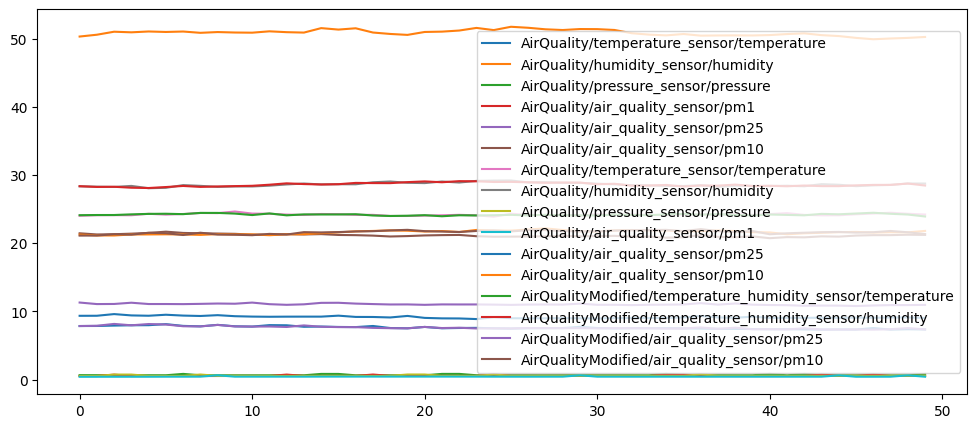

In [173]:
devs_df_slice = devs_df[
    ((devs_df.dev == 'AirQuality') | \
    (devs_df.dev == 'AirQualityModified'))]
plt.figure(figsize=(12,5))

names = []
for i,row in devs_df_slice.iterrows():
    dev_uuid = row.uuid
    dev_name, mod_name, attrib_name = row['dev'], row['mod'], row['attrib']
    ax1 = plt.plot(row[val_cols].to_list())
    names.append(dev_name + '/' + mod_name + '/' + attrib_name) 

plt.legend(names)
plt.show()

### Determine closest device UUID by buffered values comparison

Get the attribute with the closest values (euclidean distance) to each of the unknown device module attributes

In [174]:
unknown_uuid = '' # UUID of the unknown device
unknown_dev = devs_df[devs_df.dev==unknown_dev_name]
known_devs = devs_df[devs_df.dev!=unknown_dev_name]

In [175]:
# Compute closest devices by values comparison
def get_closest_devs_by_values(unknown_dev,known_devs,i) :
    # Create local copies
    unknown_row = unknown_dev.iloc[i].copy()
    knowns_alike = known_devs.copy()

    # Normalize values
    max_val, min_val = knowns_alike[val_cols].max(), knowns_alike[val_cols].min()
    knowns_alike[val_cols] = (knowns_alike[val_cols] - min_val)/(max_val-min_val)
    unknown_row[val_cols] = (unknown_row[val_cols] - min_val)/(max_val-min_val)

    # Calculate euclidean distance and get closest devices
    knowns_alike['dist'] = ((knowns_alike[val_cols] - unknown_row[val_cols])**2).sum(axis=1)**0.5
    closest_things = knowns_alike[['uuid','dev','mod','attrib','dist']].sort_values(by='dist',ascending=True)

    # Give points based on closeness
    score = 5
    vote = {}
    for row in closest_things.itertuples() :
        if score == 0 : break
        if row.uuid in vote : continue
        vote[row.uuid] = score
        score -= 1
        
    return vote

In [176]:
# Compute distance for each unknown module attribute
votes = (Parallel(n_jobs=12)(delayed(get_closest_devs_by_values)(unknown_dev,known_devs,i) for i in range(unknown_dev.shape[0])))
total_vote_dev = {}
for vote in votes:
    for candidate in vote :
        if candidate not in total_vote_dev :
            total_vote_dev[candidate] = vote[candidate]
        else :
            total_vote_dev[candidate] += vote[candidate]
total_vote_dev_df = pd.DataFrame(total_vote_dev.items(),columns=['candidate','score']).sort_values(by='score',ascending=False)

In [177]:
total_vote_dev_df

,candidate,score
0,5362cb80-381d-4d21-87ba-af283640fa98,20
1,c11c3f56-0f26-415f-a00d-3bb929f5ca20,12
2,fbeaa5f3-e532-4e02-8429-c77301f46470,9
3,f169a965-bb15-4db3-97cd-49b5b641a9fe,7
4,f342e60b-6a54-4f20-8874-89a550ebc75c,4
5,a6f65d7a-019a-4723-9b81-fb4a163fa23a,4
6,70a15d0b-f6d3-4833-b929-74abdff69fa5,3
7,45d289e7-4da6-4c10-aa6e-2c1d48b223e2,1
